# VencoPy Tutorial 4

This tutorial aims to give a more in depth overview into the GridModeler class and showcases some features that can be customised.

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yaml
import pathlib
from ruamel.yaml import YAML

path = '../..'
os.chdir(path)

from classes.dataParsers import DataParser
from classes.tripDiaryBuilders import TripDiaryBuilder
from classes.gridModelers import GridModeler
from classes.flexEstimators import FlexEstimator
from classes.evaluators import Evaluator

print("Current working directory: {0}".format(os.getcwd()))

Current working directory: C:\8_Work\VencoPy\VencoPy_internal\vencopy


In [2]:
pathGlobalConfig = pathlib.Path.cwd() / 'config' / 'globalConfig.yaml'
with open(pathGlobalConfig) as ipf:
    globalConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathLocalPathConfig = pathlib.Path.cwd()  / 'config' / 'localPathConfig.yaml'
with open(pathLocalPathConfig) as ipf:
    localPathConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathParseConfig = pathlib.Path.cwd()  / 'config' / 'parseConfig.yaml'
with open(pathParseConfig) as ipf:
    parseConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathTripConfig = pathlib.Path.cwd()  / 'config' / 'tripConfig.yaml'
with open(pathTripConfig) as ipf:
    tripConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathGridConfig = pathlib.Path.cwd()  / 'config' / 'gridConfig.yaml'
with open(pathGridConfig) as ipf:
    gridConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathEvaluatorConfig = pathlib.Path.cwd()  / 'config' / 'evaluatorConfig.yaml'
with open(pathEvaluatorConfig) as ipf:
    evaluatorConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
pathFlexConfig = pathlib.Path.cwd()  / 'config' / 'flexConfig.yaml'
with open(pathFlexConfig) as ipf:
    flexConfig = yaml.load(ipf, Loader=yaml.SafeLoader)
    
    
# Set reference dataset 
datasetID = 'MiD17'

# Modify the localPathConfig file to point to the .csv file in the sampling folder in the tutorials directory where the dataset for the tutorials lies.
localPathConfig['pathAbsolute'][datasetID] = pathlib.Path.cwd() / 'tutorials' / 'data_sampling'

# Assign to vencoPyRoot the folder in which you cloned your repository
localPathConfig['pathAbsolute']['vencoPyRoot'] = pathlib.Path.cwd()

# Similarly we modify the datasetID in the global config file
globalConfig['files'][datasetID]['tripsDataRaw'] = datasetID + '.csv'

# We also modify the parseConfig by removing some of the columns that are normally parsed from the MiD, which are not available in our semplified test dataframe
del parseConfig['dataVariables']['hhID'] 
del parseConfig['dataVariables']['personID'] 

## GridModeler config file

Let's print the GridModeler config file.

In [3]:
yaml.dump(gridConfig, sys.stdout)

chargingInfrastructureDistributions:
  DRIVING:
    1: 0
  HOME:
    0.7: 3.6
  LEISURE:
    0.5: 11
  NA:
    1: 0
  OTHER:
    0.5: 11
  SCHOOL:
    0.5: 11
  SHOPPING:
    0.5: 11
  WORK:
    0.5: 11
chargingInfrastructureMappings:
  DRIVING: false
  HOME: true
  LEISURE: false
  NA: false
  OTHER: false
  SCHOOL: false
  SHOPPING: false
  WORK: false
gridAvailabilityDistribution:
  '0.0':
    1: 0
  DRIVING:
    1: 0
  HOME:
    0.05: 22
    0.2: 0
    0.25: 11
    0.5: 3.6
  LEISURE:
    0.2: 22
    0.35: 11
    0.45: 0
  OTHER:
    0.1: 22
    0.2: 11
    0.7: 0
  SCHOOL:
    0.2: 22
    0.35: 11
    0.45: 0
  SHOPPING:
    0.2: 22
    0.35: 11
    0.45: 0
  WORK:
    0.2: 22
    0.3: 0
    0.5: 11
gridAvailabilityFastCharging:
  '0.0':
    1: 0
  DRIVING:
    1: 0
  HOME:
    0.05: 22
    0.2: 0
    0.25: 11
    0.5: 3.6
  LEISURE:
    0.2: 50
    0.35: 0
    0.45: 75
  OTHER:
    0.1: 22
    0.2: 11
    0.7: 0
  SCHOOL:
    0.2: 22
    0.35: 11
    0.45: 0
  SHOPPING:
    0.2: 

As we can see the GridModeler config file contains two keys: chargingInfrastructureMappings and chargingInfrastructureDistributions. The first one basically sets for which trip purpose the infrastructure availability should be considered, the second one specifies the probabilities given for each location (trip purpose) and the respective charging power.

## _GridModeler_ class

The charging infrastructure allocation makes use of a basic charging infrastructure model, which assumes the availability of charging stations when vehicles are parked. Since the analytical focus of the framework lies on a regional level (NUTS1-NUTS0), the infrastructure model is kept simple in the current version.

Charging availability is allocated based on a binary True–False mapping to a respective trip purpose in the VencoPy-config. Thus, different scenarios describing different charging availability scenarios, e.g., at home or at home and at work etc. can be distinguished, but neither a regional differentiation nor a charging availability probability or distribution are assumed.

At the end of the execution of the GridModeler class, a given parking purpose diary parkingType(v,t) is transferred into a binary grid connection diary connectgrid(v,t) with the same format but consisting only of True–False values.

In [4]:
# Run the first two classes to generate data
vpData = DataParser(datasetID=datasetID, parseConfig=parseConfig, globalConfig=globalConfig, localPathConfig=localPathConfig, loadEncrypted=False)
vpTripDiary = TripDiaryBuilder(datasetID=datasetID, tripConfig=tripConfig, globalConfig=globalConfig, ParseData=vpData)

Parsing properties set up
Starting to retrieve local data file from C:\8_Work\VencoPy\VencoPy_internal\vencopy\tutorials\data_sampling\MiD17.csv
Finished loading 2124 rows of raw data of type .csv
Finished harmonization of variables
Starting filtering, applying 8 filters.
The following values were taken into account after filtering:
{'isMIVDriver': 1287,
 'tripDistance': 1948,
 'tripEndClock': 2124,
 'tripEndHour': 2124,
 'tripIsIntermodal': 1682,
 'tripPurpose': 2115,
 'tripStartClock': 2124,
 'tripStartHour': 2124}
All filters combined yielded a total of 950 was taken into account
This corresponds to 44.72693032015066 percent of the original data
Parsing completed
Calculating hourly shares
Trip distance diary setup starting
Starting trip purpose diary setup
Finished purpose replacements
There are 267 daily trip diaries.
Drive data and trip purposes written to files inputProfiles_Drive_masterBranch_MiD17.csv and inputProfiles_Purpose_masterBranch_MiD17.csv


In [5]:
vpGrid = GridModeler(gridConfig=gridConfig, globalConfig=globalConfig, datasetID=datasetID)
vpGrid.assignSimpleGridViaPurposes()
vpGrid.writeOutGridAvailability()

Starting with charge connection replacement of location purposes
Grid connection assignment complete


In [6]:
vpFlex = FlexEstimator(flexConfig=flexConfig, globalConfig=globalConfig, evaluatorConfig=evaluatorConfig, datasetID=datasetID, ParseData=vpData)
vpFlex.baseProfileCalculation()
vpFlex.filter()
vpFlex.aggregate()
vpFlex.correct()
vpFlex.normalize()
vpFlex.writeOut()

Reading Venco input scalars, drive profiles and boolean plug profiles
There are 267 drive profiles and 267 plug profiles.
Flex Estimator initialization complete
Starting with iteration 0
9976.124148541114
Starting with iteration 1
0.0
Starting with iteration 2
0.0
0.0
0.0
0.0
Base profile calculation complete for dataset MiD17
There are 262 considered profiles and 259 DSM eligible profiles.


Evaluator initialization complete


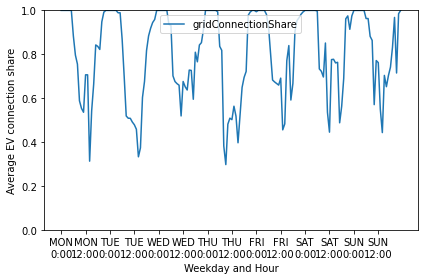

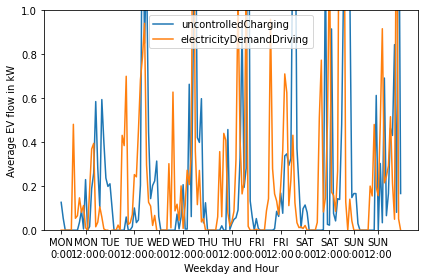

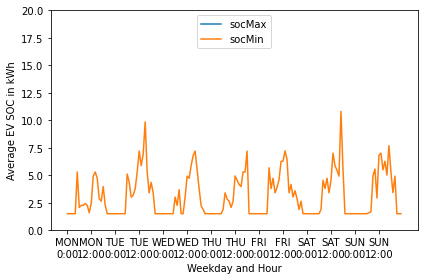

In [7]:
vpEval = Evaluator(globalConfig=globalConfig, evaluatorConfig=evaluatorConfig, parseData=pd.Series(data=vpData, index=[datasetID]))
vpEval.plotProfiles(flexEstimator=vpFlex)

We can now change the grid availability from home to the workplace only and see how this affects the available charging flexibility.

In [8]:
gridConfig['chargingInfrastructureMappings']['HOME'] = False
gridConfig['chargingInfrastructureMappings']['WORK'] = True
yaml.dump(gridConfig, sys.stdout)

chargingInfrastructureDistributions:
  DRIVING:
    1: 0
  HOME:
    0.7: 3.6
  LEISURE:
    0.5: 11
  NA:
    1: 0
  OTHER:
    0.5: 11
  SCHOOL:
    0.5: 11
  SHOPPING:
    0.5: 11
  WORK:
    0.5: 11
chargingInfrastructureMappings:
  DRIVING: false
  HOME: false
  LEISURE: false
  NA: false
  OTHER: false
  SCHOOL: false
  SHOPPING: false
  WORK: true
gridAvailabilityDistribution:
  '0.0':
    1: 0
  DRIVING:
    1: 0
  HOME:
    0.05: 22
    0.2: 0
    0.25: 11
    0.5: 3.6
  LEISURE:
    0.2: 22
    0.35: 11
    0.45: 0
  OTHER:
    0.1: 22
    0.2: 11
    0.7: 0
  SCHOOL:
    0.2: 22
    0.35: 11
    0.45: 0
  SHOPPING:
    0.2: 22
    0.35: 11
    0.45: 0
  WORK:
    0.2: 22
    0.3: 0
    0.5: 11
gridAvailabilityFastCharging:
  '0.0':
    1: 0
  DRIVING:
    1: 0
  HOME:
    0.05: 22
    0.2: 0
    0.25: 11
    0.5: 3.6
  LEISURE:
    0.2: 50
    0.35: 0
    0.45: 75
  OTHER:
    0.1: 22
    0.2: 11
    0.7: 0
  SCHOOL:
    0.2: 22
    0.35: 11
    0.45: 0
  SHOPPING:
    0.2: 

In [9]:
vpGrid = GridModeler(gridConfig=gridConfig, globalConfig=globalConfig, datasetID=datasetID)
vpGrid.assignSimpleGridViaPurposes()
vpGrid.writeOutGridAvailability()

Starting with charge connection replacement of location purposes
Grid connection assignment complete


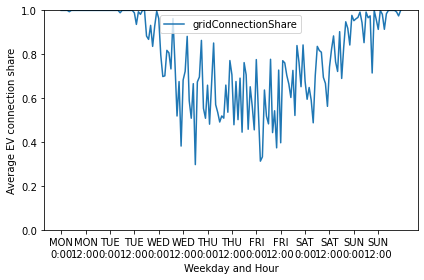

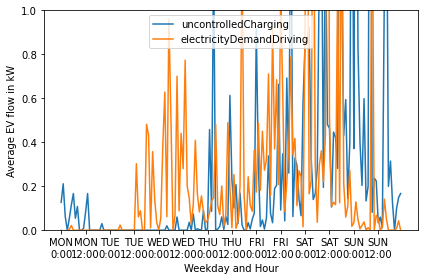

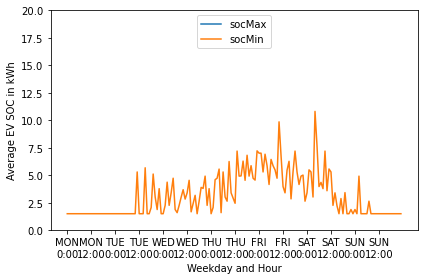

In [10]:
vpEval.plotProfiles(flexEstimator=vpFlex)

From the plots we can see how in the case of home charging, the grid connenction share varies between 0.4 and 1 for the fleet and it is 'homogeneously' distributed throughout the week, whereas in the workplace charging scenario it is limited to working days. 

## Next Steps

In the next tutorial, you will learn more in detail the internal workings of the FlexEstimator class and how to customise some settings.